In [2]:
#RMSE and ACC table
import os 
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
import hydra
import numpy as np
from hydra import compose, initialize
from omegaconf import OmegaConf
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")


In [3]:
import subprocess
import os 
os.environ['SLURM_NTASKS_PER_NODE'] = '1'
scratch = os.environ['SCRATCH']
run_id = '9cbb1f05'
out = subprocess.run(f'ls -tr {scratch}/checkpoint_{run_id}/ | tail -n 1',shell=True,capture_output=True,text=True)
path = out.stdout.strip("\n")
checkpoint_path = f'{scratch}/checkpoint_{run_id}/{path}'
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
test = IPSL_DCPP(
    'test',
    lead_time_months=1,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    delta=True,
    generate_statistics=False,
    normalization='normal'
)
train = IPSL_DCPP(
    'train',
    lead_time_months=1,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    delta=True,
    generate_statistics=False,
    normalization='norma;'
)
test_dataloader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False,num_workers=1)
train_dataloader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False,num_workers=1)

model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone
        ,conv_head=True
    ),
    dataset=test_dataloader.dataset
)
model.load_state_dict(checkpoint['state_dict'])



/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: Error(s) in loading state_dict for ForecastModule:
	Missing key(s) in state_dict: "backbone.patchrecovery2d.conv.weight", "backbone.patchrecovery2d.conv.bias", "backbone.depth_patchrecovery3d.conv.weight", "backbone.depth_patchrecovery3d.conv.bias". 
	Unexpected key(s) in state_dict: "backbone.patchrecovery.head1.0.weight", "backbone.patchrecovery.head1.0.bias", "backbone.patchrecovery.head1.2.weight", "backbone.patchrecovery.head1.2.bias", "backbone.patchrecovery.head1.4.weight", "backbone.patchrecovery.head1.4.bias", "backbone.patchrecovery.proj.weight", "backbone.patchrecovery.proj.bias". 

In [24]:
trainer = pl.Trainer(fast_dev_run=12)
output = trainer.predict(model, test_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 12 batch(es). Logging and checkpointing is suppressed.
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 12/12 [01:01<00:00,  0.20it/s]


In [35]:
def acc(x, y, coeffs, dims=(-2, -1)):
   norm = (x*x).mul(coeffs).mean(dims)**.5
   mean_acc = (x*y).mul(coeffs).mean(dims) / norm / (y*y).mul(coeffs).mean(dims)**.5
   return mean_acc



In [32]:
output[i][0].keys()

dict_keys(['latent', 'next_state_surface', 'next_state_depth'])

In [38]:
accs = []
lat_coeffs_equi = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])
lat_coeffs_equi =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]

for i in range(12):
    preds = output[i][0]['next_state_surface']*test.surface_delta_stds + output[i][1]['state_surface']
    batch = output[i][1]['next_state_surface']*test.surface_delta_stds + output[i][1]['state_surface']
    mean_acc = acc(preds,batch,lat_coeffs_equi)
    accs.append(mean_acc)



In [6]:
test.surface_variables.index('cVeg')

6

In [41]:
mean_accs = np.array(accs).squeeze().mean(axis=0)

In [42]:
mean_accs[test.surface_variables.index('gpp')],mean_accs[test.surface_variables.index('tas')],mean_accs[test.surface_variables.index('evspsblsoi')],mean_accs[test.surface_variables.index('cVeg')]



(0.7163535, 0.41102865, 0.3087246, 0.9696212)

In [9]:
preds = []
actuals = []
for i in range(0,11):
    print(i)
    denormed_preds,denormed_batch = test.denormalize(output[i][0],output[i][1])
    preds.append(np.nanmean(denormed_preds['next_state_surface'].squeeze()[89]))
    actuals.append(np.nanmean(denormed_batch['next_state_surface'].squeeze()[89]))

0
1
2
3
4
5
6
7
8
9
10


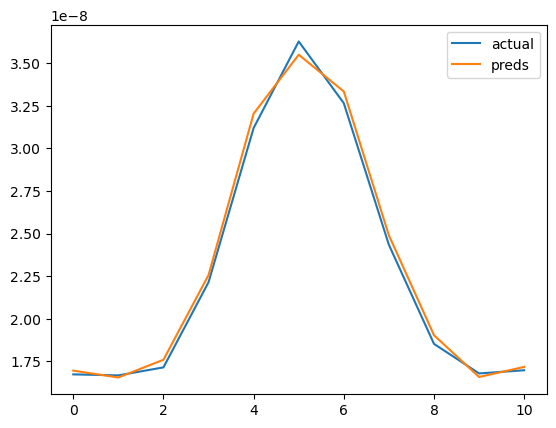

In [10]:
import matplotlib.pyplot as plt
plt.plot(actuals,label='actual')
plt.plot(preds,label='preds')
plt.legend()

In [42]:
output[i][1]['next_state_surface'].squeeze()

torch.Size([1, 1, 91, 143, 144])

In [ ]:
output[0][0]['next_state_surface']

In [21]:
mse_surface = (output[0][0]['next_state_surface'] - output[0][1]['next_state_surface']).abs().pow(2)

lat_coeffs_equi = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])
lat_coeffs_equi =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]
#if mse_surface.shape[-2] == 128:
#    mse_surface = mse_surface[..., 4:-4, 8:-8]
mse_surface = mse_surface.mul(lat_coeffs_equi)

In [30]:
means = mse_surface.squeeze().mean((1,2))

In [3]:
import numpy as np
np.load('../data/surface_means.npy').shape

(91,)

In [33]:
for var_index in range(len(surface_variables)):
    var_name = surface_variables[var_index]
    acc = np.round(output[0][0].squeeze()[var_index].item(),2)
    pred_mean_value = np.round(output[0][1].squeeze()[var_index].item(),2)
    batch_mean_value = np.round(output[0][2].squeeze()[var_index].item(),2)
    mse = np.sqrt(np.round(means[var_index].item(),2))
    print(var_name,acc,pred_mean_value,batch_mean_value,mse)

baresoilFrac 0.96 15.4 15.35 21.56
c3PftFrac 0.97 59.14 59.03 22.88
c4PftFrac 0.98 7.25 7.14 3.58
cLeaf 0.98 0.08 0.08 0.0
cLitter 0.98 0.72 0.73 0.0
cLitterAbove 0.98 0.54 0.55 0.0
cLitterBelow 0.97 0.18 0.18 0.0
cProduct 0.91 0.02 0.02 0.0
cRoot 0.99 0.5 0.51 0.01
cSoilFast 0.98 0.06 0.06 0.0
cSoilMedium 0.99 1.53 1.53 0.01
cSoilSlow 0.98 2.22 2.19 0.03
cVeg 0.99 2.27 2.28 0.13
cropFrac 0.95 8.38 8.33 7.29
mrsos 0.91 19.9 19.92 3.68
evspsblsoi 0.8 0.0 0.0 0.0
evspsblveg 0.94 0.0 0.0 0.0
fHarvest 0.91 0.0 0.0 0.0
fLitterSoil 0.97 0.0 0.0 0.0
fVegLitter 0.94 0.0 0.0 0.0
grassFrac 0.96 27.18 27.16 12.31
lai 0.98 1.26 1.27 0.04
mrfso 0.9 57.27 57.45 725.8
mrro 0.84 0.0 0.0 0.0
mrros 0.79 0.0 0.0 0.0
mrso 0.93 486.1 487.61 1283.79
prveg 0.94 0.0 0.0 0.0
rGrowth 0.97 -0.0 -0.0 0.0
rMaint 0.99 -0.0 -0.0 0.0
ra 0.99 0.0 0.0 0.0
rh 0.98 0.0 0.0 0.0
tran 0.94 0.0 0.0 0.0
treeFrac 0.97 30.85 30.69 12.15
treeFracPrimDec 0.96 14.15 14.19 5.62
treeFracPrimEver 0.98 16.7 16.5 7.05
ci 0.95 0.63 0.62